In [22]:
#import gym
import json
#import math
import numpy as np 
#from gym.utils import seeding
#from gym import error, spaces, utils
from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import mean_squared_error
from concurrent import futures


class TradingEnv:
        metadata = {'render.modes': ['human']}
        def __init__(self , market_data):
            self.Index                             = 0
            self.Cash                              = [0]
            self.Coin                              = [0]
            self.Gain                              = [0]
            self.Reward                            = [0]
            self.AccGain                           = [0]
            self.AccReward                         = [0]
            self.MarketGain                        = [0]            
            self.Volatility                        = [0]
            self.Action                            = 0
            self.vwindow                           = 20 #volatility window
            self.NoOfActions                       = 11
            self.FillType                          = [0]
            self.Actionspace                       = np.linspace(-1, 1, num=self.NoOfActions)
            self.EffictiveRate                     = [0] # -ve for sell orders +ve for buy orders zero for no action
            self.Tradingfee                        = 0.01
            self.Tick_Ask_Scaler                   = MinMaxScaler(feature_range=(0, 1))
            self.Tick_Bid_Scaler                   = MinMaxScaler(feature_range=(0, 1))
            self.Tick_Last_Scaler                  = MinMaxScaler(feature_range=(0, 1))
            self.OrderBook_buy_Rate_Scaler         = MinMaxScaler(feature_range=(0, 1))
            self.OrderBook_sell_Quantity_Scaler    = MinMaxScaler(feature_range=(0, 1))
            self.OrderBook_sell_Rate_Scaler        = MinMaxScaler(feature_range=(0, 1))
            self.MarketHistory_Price_Scaler        = MinMaxScaler(feature_range=(0, 1))
            self.MarketHistory_Quantity_Scaler     = MinMaxScaler(feature_range=(0, 1))
            self.OrderBook_buy_Quantity_Scaler     = MinMaxScaler(feature_range=(0, 1))
            self.Sell_Active_volum_Scaler          = MinMaxScaler(feature_range=(0, 1))
            self.Buy_Active_volum_Scaler           = MinMaxScaler(feature_range=(0, 1))
            self.Total_Active_Volum_Scaler         = MinMaxScaler(feature_range=(0, 1))
            self.Historical_Volum_Scaler           = MinMaxScaler(feature_range=(0, 1))
            self.Market_Data                       = market_data
            self.Action_log                        = []
            self.Volum_log                         = []
            self.Last_Significant_Action           = np.array([0,0,0,0,0,0]) # contains (coin , cash , Effrate , action , fillType , index)  action != 0 ,-1 to 1
            json_data                              = []
            with open(self.Market_Data) as file :
                for line in file:
                    json_data.append(json.loads(line))

            global json_data
            # convert an array of values into a dataset matrix
            Tick_Ask                   = []             
            Tick_Bid                   = []
            Tick_Last                  = []
            OrderBook_buy_Rate         = []
            OrderBook_buy_Quantity     = []
            OrderBook_sell_Quantity    = []
            OrderBook_sell_Rate        = []
            MarketHistory_Price        = []
            MarketHistory_Quantity     = []
            MarketHistory_FillType_Z   = [] #-1/1 encodecd
            MarketHistory_OrderType_Z  = []
            Sell_Active_volum          = []
            Buy_Active_volum           = []
            Total_Active_Volum         = []
            Historical_Volum           = []
            depth = 100
            global Tick_Ask
            global Tick_Bid
            global Tick_Last
            global OrderBook_buy_Rate
            global OrderBook_buy_Quantity
            global OrderBook_sell_Quantity
            global OrderBook_sell_Rate
            #global MarketHistory_Price
            #global MarketHistory_Quantity
            #global MarketHistory_FillType_Z
            #global MarketHistory_OrderType_Z
            #global Sell_Active_volum
            #global Buy_Active_volum
            #global Total_Active_Volum
            #global Historical_Volum
            with futures.ThreadPoolExecutor(max_workers=5) as ex:
                #print('main: starting')
                #ex.submit(self._Extract_OrderBook_Buy )
                #ex.submit(self._Extract_OrderBook_Sell )
                ex.submit(self._Extract_Tick  )
                #ex.submit(self._Extract_MarketHistory )



            self.Tick_Last                  = Tick_Last


            #Clean Up
            #-------------------------#
            del json_data
            #-------------------------#  
            self.Last_index = len(Tick_Last)
            '''
            #MarketHistory_Price             = np.reshape(MarketHistory_Price, (int(len(MarketHistory_Price)/depth),depth))
            #MarketHistory_Quantity          = np.reshape(MarketHistory_Quantity, (int(len(MarketHistory_Quantity)/depth),depth))
            #MarketHistory_FillType_Z        = np.reshape(MarketHistory_FillType_Z, (int(len(MarketHistory_FillType_Z)/depth),depth))
            #MarketHistory_OrderType_Z       = np.reshape(MarketHistory_OrderType_Z, (int(len(MarketHistory_OrderType_Z)/depth),depth))
            OrderBook_buy_Quantity          = np.reshape(OrderBook_buy_Quantity, (int(len(OrderBook_buy_Quantity)/depth),depth))
            OrderBook_buy_Rate              = np.reshape(OrderBook_buy_Rate, (int(len(OrderBook_buy_Rate)/depth),depth))
            OrderBook_sell_Quantity         = np.reshape(OrderBook_sell_Quantity,(int(len(OrderBook_sell_Quantity)/depth),depth))
            OrderBook_sell_Rate             = np.reshape(OrderBook_sell_Rate,(int(len(OrderBook_sell_Rate)/depth),depth))
            #Buy_Active_volum                = np.reshape(Buy_Active_volum ,(1,len(Buy_Active_volum)))
            #Sell_Active_volum               = np.reshape(Sell_Active_volum ,(1,len(Sell_Active_volum)))
            #Historical_Volum                = np.reshape(Historical_Volum ,(1,len(Historical_Volum)))
            #Total_Active_Volum              = Buy_Active_volum + Sell_Active_volum
            #Tick_Ask                        = np.reshape(Tick_Ask ,(1,len(Tick_Ask)))
            #Tick_Bid                        = np.reshape(Tick_Bid ,(1,len(Tick_Bid)))
            Tick_Last                       = np.reshape(Tick_Last ,(1,len(Tick_Last)))
            
            #Tick_Ask_Norm                   = self.Tick_Ask_Scaler.fit_transform( Tick_Ask.T ).T #we rotat the  input to normalize over the time aixs and re rotate it to be sutale for concatination in the state matrix
            #Tick_Bid_Norm                   = self.Tick_Bid_Scaler.fit_transform( Tick_Bid.T ).T
            #Tick_Last_Norm                  = self.Tick_Last_Scaler.fit_transform(  Tick_Last.T ).T
            OrderBook_buy_Rate_Norm         = self.OrderBook_buy_Rate_Scaler.fit_transform(  OrderBook_buy_Rate )
            OrderBook_sell_Quantity_Norm    = self.OrderBook_sell_Quantity_Scaler.fit_transform(  OrderBook_sell_Quantity )
            OrderBook_sell_Rate_Norm        = self.OrderBook_sell_Rate_Scaler.fit_transform(  OrderBook_sell_Rate )
            #MarketHistory_Price_Norm        = self.MarketHistory_Price_Scaler.fit_transform(  MarketHistory_Price )
            #MarketHistory_Quantity_Norm     = self.MarketHistory_Quantity_Scaler.fit_transform(  MarketHistory_Quantity )
            OrderBook_buy_Quantity_Norm     = self.OrderBook_buy_Quantity_Scaler.fit_transform(  OrderBook_buy_Quantity )
            #Sell_Active_volum_Norm          = self.Sell_Active_volum_Scaler.fit_transform(  Sell_Active_volum.T ).T
            #Buy_Active_volum_Norm           = self.Buy_Active_volum_Scaler.fit_transform(  Buy_Active_volum.T ).T
            #Total_Active_Volum_Norm         = self.Total_Active_Volum_Scaler.fit_transform(  Total_Active_Volum.T ).T
            #Historical_Volum_Norm           = self.Historical_Volum_Scaler.fit_transform(  Historical_Volum.T ).T
            
            
            
            #Tick_Ask_Norm                   = self._repeatN(Tick_Ask_Norm,100)
            #Tick_Bid_Norm                   = self._repeatN(Tick_Bid_Norm,100)
            #Tick_Last_Norm                  = self._repeatN(Tick_Last_Norm,100)
            #Buy_Active_volum_Norm           = self._repeatN(Buy_Active_volum_Norm,100)
            #Sell_Active_volum_Norm          = self._repeatN(Sell_Active_volum_Norm,100)
            #Historical_Volum_Norm           = self._repeatN(Historical_Volum_Norm,100)
            #Total_Active_Volum_Norm         = self._repeatN(Total_Active_Volum_Norm,100)

            
            self.OrderBook_buy_Rate         = OrderBook_buy_Rate
            self.OrderBook_sell_Quantity    = OrderBook_sell_Quantity
            self.OrderBook_sell_Rate        = OrderBook_sell_Rate
            self.OrderBook_buy_Quantity     = OrderBook_buy_Quantity
            self.Tick_Last                  = Tick_Last.T
            '''
            '''
            self.Tick_Ask1                  = Tick_Ask
            self.Tick_Ask                   = Tick_Ask_Norm             
            self.Tick_Bid                   = Tick_Bid_Norm
            self.Tick_Last                  = Tick_Last_Norm
            self.MarketHistory_Price        = MarketHistory_Price_Norm
            self.MarketHistory_Quantity     = MarketHistory_Quantity_Norm
            self.MarketHistory_FillType_Z   = MarketHistory_FillType_Z #ZERO encodecd
            self.MarketHistory_OrderType_Z  = MarketHistory_OrderType_Z
            self.Sell_Active_volum          = Sell_Active_volum_Norm
            self.Buy_Active_volum           = Buy_Active_volum_Norm
            self.Total_Active_Volum         = Total_Active_Volum_Norm
            self.Historical_Volum           = Historical_Volum_Norm
            '''
            '''
            Input_Feturs      = np.concatenate((
                                   #Tick_Ask_Norm,
                                   #Tick_Bid_Norm,
                                   #Tick_Last_Norm,
                                   OrderBook_buy_Rate_Norm,
                                   OrderBook_buy_Quantity_Norm,
                                   OrderBook_sell_Quantity_Norm,
                                   OrderBook_sell_Rate_Norm
                                   #MarketHistory_Price_Norm,
                                   #MarketHistory_Quantity_Norm,
                                   #MarketHistory_FillType_Z,
                                   #MarketHistory_OrderType_Z,
                                   #Buy_Active_volum_Norm,
                                   #Sell_Active_volum_Norm,
                                   #Historical_Volum_Norm,
                                   #Total_Active_Volum_Norm

                                  ),axis = 1)
            self.EnvStats      = np.reshape(Input_Feturs,[Input_Feturs.shape[0],int(Input_Feturs.shape[1]/20),20])
            '''
            #Clean Up
            #----------------------------------#
            #del MarketHistory_Price
            #del MarketHistory_Quantity
            #del MarketHistory_FillType_Z  #-1/1 encodecd
            #del MarketHistory_OrderType_Z
            #del OrderBook_buy_Quantity 
            #del OrderBook_buy_Rate 
            #del OrderBook_sell_Quantity
            #del OrderBook_sell_Rate 
            #del Tick_Ask
            #del Tick_Bid
            #del Tick_Last
            #del Sell_Active_volum
            #del Buy_Active_volum
            #del Total_Active_Volum
            #del Historical_Volum
            #del Input_Feturs
            #del MarketHistory_Price_Norm
            #del MarketHistory_Quantity_Norm
            #del OrderBook_buy_Quantity_Norm
            #del OrderBook_buy_Rate_Norm 
            #del OrderBook_sell_Quantity_Norm
            #del OrderBook_sell_Rate_Norm 
            #del Tick_Ask_Norm
            #del Tick_Bid_Norm
            #del Tick_Last_Norm
            #del Sell_Active_volum_Norm
            #del Buy_Active_volum_Norm
            #del Total_Active_Volum_Norm
            #del Historical_Volum_Norm
           #--------------------------------------#

        '''
        def _Extract_OrderBook_Sell(self):
            global OrderBook_sell_Rate
            global OrderBook_sell_Quantity
            #print('sell: starting')
            global json_data
            for i in range(len(json_data)):

                if ((json_data[i] != [] or None) and
                        (json_data[i]['Tick'] != [] or None) and
                        (json_data[i]['OrderBook'] != [] or None) and
                        (json_data[i]['MarketHistory'] != [] or None) and
                        (json_data[i]['Tick']['result'] is not None) and
                        (json_data[i]['OrderBook']['result'] is not None) and
                        (json_data[i]['MarketHistory']['result'] is not None) and
                        (json_data[i]['MarketHistory']['result'] != [] or None) and
                        (json_data[i]['OrderBook']['result']['buy'] != [] or None) and
                        (json_data[i]['OrderBook']['result']['sell'] != [] or None) and
                        (json_data[i]['Tick']['result'] != [] or None) and
                        (json_data[i]['Tick']['result']['Ask'] != [] or None) and
                        (json_data[i]['Tick']['result']['Bid'] != [] or None) and
                        (json_data[i]['Tick']['result']['Last'] != [] or None)
                ):


                    for m in range(len((json_data[1]['OrderBook']['result']['sell']))):
                        OrderBook_sell_Quantity.append(json_data[i]['OrderBook']['result']['sell'][m]['Quantity'])
                        OrderBook_sell_Rate.append(json_data[i]['OrderBook']['result']['sell'][m]['Rate'])
                    #Sell_Active_volum.append(sum(OrderBook_sell_Rate))
        

        def _Extract_OrderBook_Buy(self):
            #print('buy: starting')
            global OrderBook_buy_Rate
            global OrderBook_buy_Quantity
            global json_data
            for i in range(len(json_data)):

                if ((json_data[i] != [] or None) and
                        (json_data[i]['Tick'] != [] or None) and
                        (json_data[i]['OrderBook'] != [] or None) and
                        (json_data[i]['MarketHistory'] != [] or None) and
                        (json_data[i]['Tick']['result'] is not None) and
                        (json_data[i]['OrderBook']['result'] is not None) and
                        (json_data[i]['MarketHistory']['result'] is not None) and
                        (json_data[i]['MarketHistory']['result'] != [] or None) and
                        (json_data[i]['OrderBook']['result']['buy'] != [] or None) and
                        (json_data[i]['OrderBook']['result']['sell'] != [] or None) and
                        (json_data[i]['Tick']['result'] != [] or None) and
                        (json_data[i]['Tick']['result']['Ask'] != [] or None) and
                        (json_data[i]['Tick']['result']['Bid'] != [] or None) and
                        (json_data[i]['Tick']['result']['Last'] != [] or None)
                ):

                    for m in range(len((json_data[1]['OrderBook']['result']['buy']))):
                        OrderBook_buy_Quantity.append(json_data[i]['OrderBook']['result']['buy'][m]['Quantity'])
                        OrderBook_buy_Rate.append(json_data[i]['OrderBook']['result']['buy'][m]['Rate'])
                    #Buy_Active_volum.append(sum(OrderBook_buy_Rate))

        def _Extract_MarketHistory(self):
            #print('history: starting')
            global MarketHistory_Price
            global MarketHistory_Quantity
            global MarketHistory_FillType_Z
            global MarketHistory_OrderType_Z
            global MarketHistory_OrderType_Z
            global Sell_Active_volum
            global Buy_Active_volum
            global Total_Active_Volum
            global Historical_Volum
            global json_data
            for i in range(len(json_data)):

                if ((json_data[i] != [] or None) and
                        (json_data[i]['Tick'] != [] or None) and
                        (json_data[i]['OrderBook'] != [] or None) and
                        (json_data[i]['MarketHistory'] != [] or None) and
                        (json_data[i]['Tick']['result'] is not None) and
                        (json_data[i]['OrderBook']['result'] is not None) and
                        (json_data[i]['MarketHistory']['result'] is not None) and
                        (json_data[i]['MarketHistory']['result'] != [] or None) and
                        (json_data[i]['OrderBook']['result']['buy'] != [] or None) and
                        (json_data[i]['OrderBook']['result']['sell'] != [] or None) and
                        (json_data[i]['Tick']['result'] != [] or None) and
                        (json_data[i]['Tick']['result']['Ask'] != [] or None) and
                        (json_data[i]['Tick']['result']['Bid'] != [] or None) and
                        (json_data[i]['Tick']['result']['Last'] != [] or None)
                ):


                    for m in range(len((json_data[1]['MarketHistory']['result']))):
                        MarketHistory_Price.append(json_data[i]['MarketHistory']['result'][m]['Price'])
                        MarketHistory_Quantity.append(json_data[i]['MarketHistory']['result'][m]['Quantity'])

                        if (json_data[i]['MarketHistory']['result'][m]['FillType']) == 'PARTIAL_FILL':
                            MarketHistory_FillType_Z.append(-1)
                        elif (json_data[i]['MarketHistory']['result'][m]['FillType']) == 'FILL':
                            MarketHistory_FillType_Z.append(1)
                        if (json_data[i]['MarketHistory']['result'][m]['OrderType']) == 'BUY':
                            MarketHistory_OrderType_Z.append(-1)
                        elif (json_data[i]['MarketHistory']['result'][m]['OrderType']) == 'SELL':
                            MarketHistory_OrderType_Z.append(1)
                    Historical_Volum.append(sum(MarketHistory_Quantity))
        '''
        def _Extract_Tick(self):
            #print('Tick: starting')
            global Tick_Ask
            global Tick_Bid
            global Tick_Last
            global json_data
            for i in range(len(json_data)):

                if ((json_data[i] != [] or None) and
                        (json_data[i]['Tick'] != [] or None) and
                        (json_data[i]['OrderBook'] != [] or None) and
                        (json_data[i]['MarketHistory'] != [] or None) and
                        (json_data[i]['Tick']['result'] is not None) and
                        (json_data[i]['OrderBook']['result'] is not None) and
                        (json_data[i]['MarketHistory']['result'] is not None) and
                        (json_data[i]['MarketHistory']['result'] != [] or None) and
                        (json_data[i]['OrderBook']['result']['buy'] != [] or None) and
                        (json_data[i]['OrderBook']['result']['sell'] != [] or None) and
                        (json_data[i]['Tick']['result'] != [] or None) and
                        (json_data[i]['Tick']['result']['Ask'] != [] or None) and
                        (json_data[i]['Tick']['result']['Bid'] != [] or None) and
                        (json_data[i]['Tick']['result']['Last'] != [] or None)
                ):

                    Tick_Ask.append(json_data[i]['Tick']['result']['Ask'])
                    Tick_Bid.append(json_data[i]['Tick']['result']['Bid'])
                    Tick_Last.append(json_data[i]['Tick']['result']['Last'])
                    #print(Tick_Last[-1])

<ipython-input-22-ce6d0d07a7b5>:53: SyntaxWarning: name 'json_data' is assigned to before global declaration
  global json_data
<ipython-input-22-ce6d0d07a7b5>:73: SyntaxWarning: name 'Tick_Last' is assigned to before global declaration
  global Tick_Last
<ipython-input-22-ce6d0d07a7b5>:74: SyntaxWarning: name 'OrderBook_buy_Rate' is assigned to before global declaration
  global OrderBook_buy_Rate
<ipython-input-22-ce6d0d07a7b5>:75: SyntaxWarning: name 'OrderBook_buy_Quantity' is assigned to before global declaration
  global OrderBook_buy_Quantity
<ipython-input-22-ce6d0d07a7b5>:76: SyntaxWarning: name 'OrderBook_sell_Quantity' is assigned to before global declaration
  global OrderBook_sell_Quantity
<ipython-input-22-ce6d0d07a7b5>:77: SyntaxWarning: name 'OrderBook_sell_Rate' is assigned to before global declaration
  global OrderBook_sell_Rate


In [23]:
env = TradingEnv('../../MarketData/USDT-BTC_Market_Trading_Data-short.txt')

In [ ]:
type(env.Tick_Last)

In [ ]:
!ls ../../MarketData

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing as t

sns.set()

In [ ]:
t.

In [2]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [33]:
df = pd.read_csv('xx1z.csv')
df.head()

,TimeStamp,Open,Close,High,Low,Volume,BaseVolume
0,6/25/2017 7:43:00 PM,2470.700000,2455.876000,2470.700000,2455.876000,0.304622,751.652981
1,6/25/2017 7:44:00 PM,2455.876000,2455.876000,2455.876000,2455.876000,0.000010,0.024976
2,6/25/2017 7:46:00 PM,2454.609204,2454.609204,2454.609204,2454.609204,0.635816,1560.679806
3,6/25/2017 7:47:00 PM,2450.000000,2455.876000,2455.876000,2450.000000,3.984698,9776.233825
4,6/25/2017 7:48:00 PM,2455.876000,2455.876000,2455.876000,2455.876000,0.059848,146.980053


In [37]:
#close = df.Close.values.tolist()
close = env.Tick_Last
window_size = 30
skip = 1
l = len(close) - 1

In [ ]:
close_real

In [38]:
close_real  = close 
close =np.reshape(close ,(int(len(close)),1))
scalerClose = MinMaxScaler(feature_range=(0, 1))
close       = scalerClose.fit_transform(close)
close = close.T.tolist()[0]

In [ ]:
scalerClose.inverse_transform(close)

In [ ]:
env.Tick_Last

In [7]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(self, weights, reward_function, population_size, sigma, learning_rate):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(self.weights, population[k])
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = w + self.learning_rate/(self.population_size * self.sigma) * np.dot(A.T, rewards).T
            if (i+1) % print_every == 0:
                print('iter %d. reward: %f' %  (i+1, self.reward_function(self.weights)))
        print('time taken to train:', time.time()-lasttime, 'seconds')
        
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [np.random.randn(input_size, layer_size), 
                        np.random.randn(layer_size, output_size),
                        np.random.randn(layer_size, 1),
                        np.random.randn(1, layer_size)]
    
    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy
    
    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [8]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03
    
    def __init__(self, model, money, max_buy, max_sell):
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(self.model.get_weights(), self.get_reward, self.POPULATION_SIZE, self.SIGMA, self.LEARNING_RATE)
    
    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])
    
    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0,l,skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, window_size + 1)
            if action == 1 and initial_money >= close_real[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close_real[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close_real[t]
                initial_money += total_sell
                
            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100
    
    def fit(self, iterations, checkpoint):
        self.es.train(iterations,print_every=checkpoint)
        
    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0,l,skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, window_size + 1)
            if action == 1 and initial_money >= close_real[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close_real[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print('day %d: buy %d units at price %f, total balance %f'%(t,buy_units, total_buy,initial_money))
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close_real[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print('day %d, sell %d units at price %f, investment %f %%, total balance %f,'%(t, sell_units, total_sell, invest, initial_money))
            state = next_state
        
        invest = ((initial_money - starting_money) / starting_money) * 100
        print('\ntotal gained %f, total investment %f %%'%(initial_money - starting_money,invest))
        plt.figure(figsize=(20,10))
        plt.plot(close_real, label='true close',c='g')
        plt.plot(close_real, 'X', label='predict buy',markevery=states_buy, c='b')
        plt.plot(close_real, 'o', label='predict sell',markevery=states_sell,c='r')
        plt.legend()
        plt.show()

In [31]:
model = Model(window_size, 500, 3)
agent = Agent(model,2000,5,5)
agent.fit(400, 10)

iter 10. reward: 21.538593
iter 20. reward: 34.565352
iter 30. reward: 52.166010
iter 40. reward: 47.116763
iter 50. reward: 55.199424
iter 60. reward: 47.705830
iter 70. reward: 33.580621
iter 80. reward: 46.752996
iter 90. reward: 70.416306
iter 100. reward: 86.133644
iter 110. reward: 83.845244
iter 120. reward: 93.184794
iter 130. reward: 97.762806
iter 140. reward: 112.960244
iter 150. reward: 117.027662
iter 160. reward: 118.611736
iter 170. reward: 118.092706
iter 180. reward: 114.080806
iter 190. reward: 108.861740
iter 200. reward: 108.230991
iter 210. reward: 134.130342
iter 220. reward: 138.544619
iter 230. reward: 140.111703
iter 240. reward: 146.159143
iter 250. reward: 139.941747
iter 260. reward: 139.803346
iter 270. reward: 143.197596
iter 280. reward: 148.870489
iter 290. reward: 150.072596
iter 300. reward: 148.009600
iter 310. reward: 151.355403
iter 320. reward: 154.578111
iter 330. reward: 155.327087
iter 340. reward: 165.234427
iter 350. reward: 164.336939
iter 36


total gained 0.000000, total investment 0.000000 %


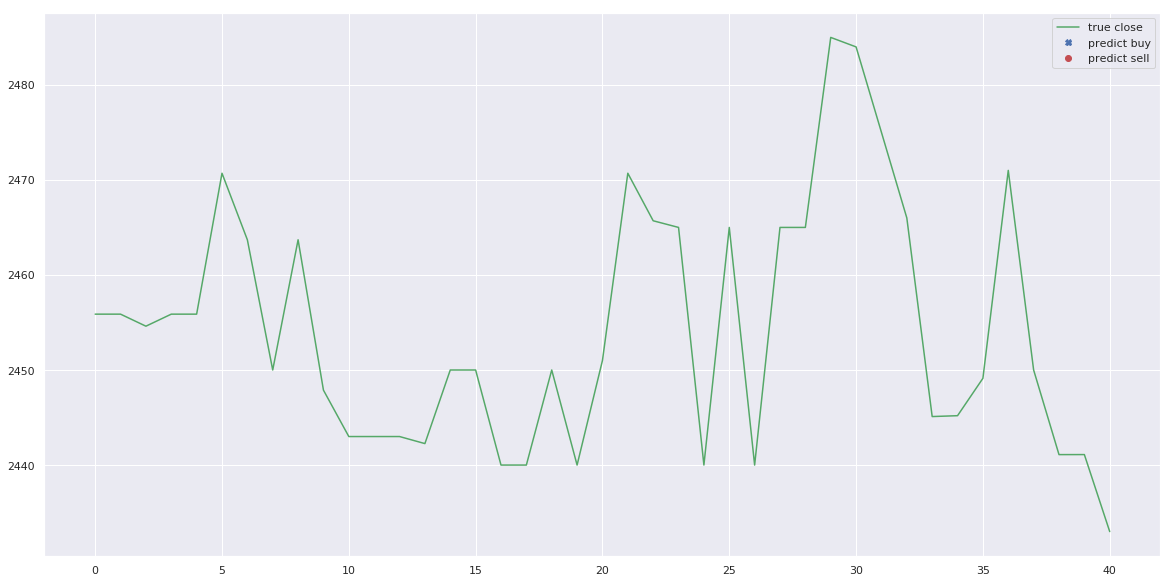

In [36]:
agent.buy()

day 2: buy 5 units at price 2048.620000, total balance -48.620000
day 5, sell 5 units at price 2019.382949, investment -1.427158 %, total balance 1970.762949,
day 8: buy 5 units at price 2019.382949, total balance -48.620000
day 11, sell 5 units at price 2004.424292, investment -0.740754 %, total balance 1955.804292,
day 14: buy 5 units at price 2004.424292, total balance -48.620000
day 16, sell 5 units at price 1997.363485, investment -0.352261 %, total balance 1948.743485,
day 21: buy 5 units at price 1839.918425, total balance 108.825061
day 22, sell 5 units at price 1878.786511, investment 2.112490 %, total balance 1987.611572,
day 25: buy 5 units at price 1875.000000, total balance 112.611572
day 26, sell 5 units at price 1942.367183, investment 3.592916 %, total balance 2054.978755,
day 27: buy 5 units at price 1860.829148, total balance 194.149607
day 28, sell 5 units at price 1907.500000, investment 2.508068 %, total balance 2101.649607,
day 29: buy 5 units at price 1855.000000

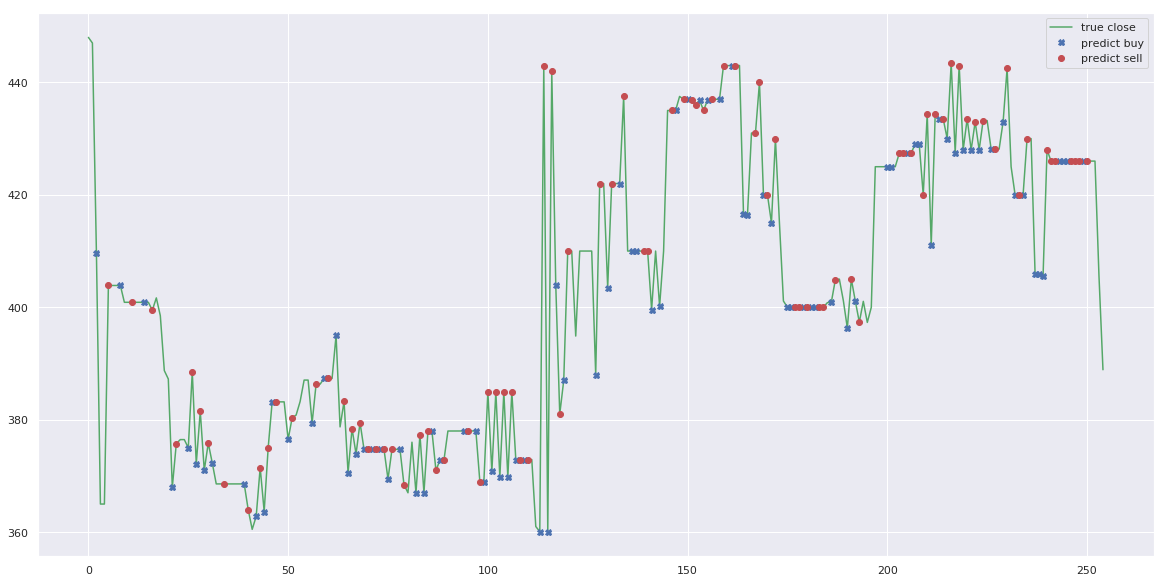

In [32]:
agent.buy()


total gained 0.000000, total investment 0.000000 %


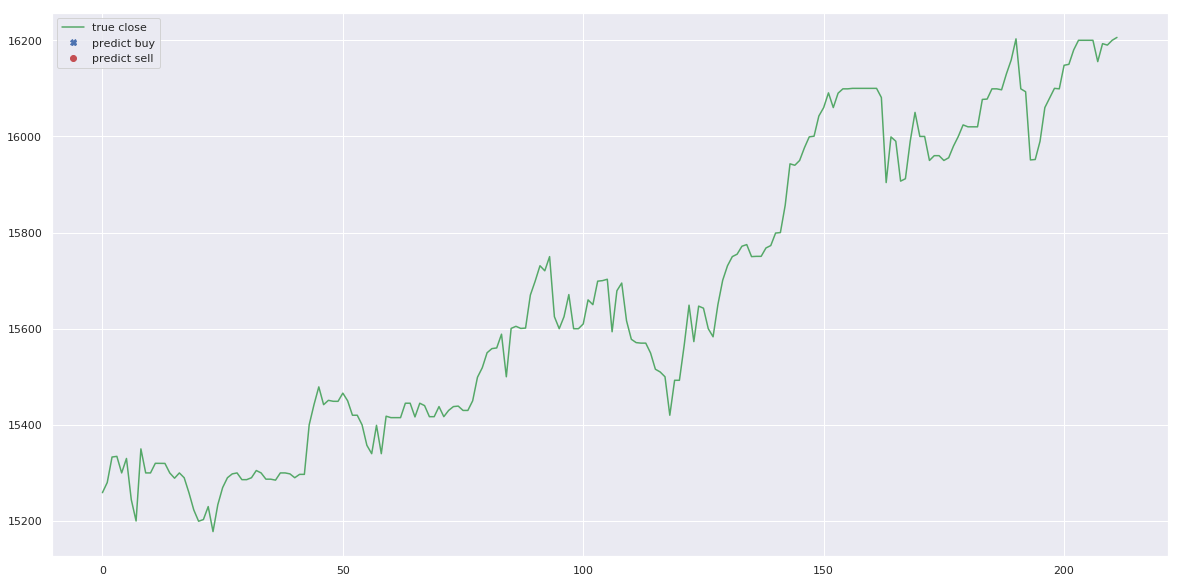

In [39]:

agent.buy()